In [ ]:
# a cactus_generator with TF-constrained optimization toolbox
# Last Update: 12/06/2021 by Fei

In [8]:
import math
import numpy as np
import scipy 
import tensorflow as tf
import tensorflow_constrained_optimization as tfco
from six.moves import xrange
from scipy.special import gamma 
from scipy.special import gammaincc

# set parameters for the distribution

iter_num=3000
learning_rate = 0.01
n=200
xmax=8
C=1
c_exp=2
r=0.9
sen=1;  #sensitivity
R=r
k = sen*n
N = int(n*xmax)
xmax = N / n
x=np.arange(-N,N+1) / n
l=len(x)

# Constrain matrix for cost
c = (np.power(x+1/2/n,c_exp+1)-np.power(x-1/2/n, c_exp+1))*n/(c_exp+1)
c[N+1] = np.power(1/2/n, c_exp)/(1+c_exp)
c[0] = c[-1] = n*r**(-N-1/2)*(-n*np.log(r))**(-c_exp-1)*gamma(c_exp+1)*gammaincc(c_exp+1,-np.log(r)*(N-1/2))
c = np.matrix(c)

# Constrain on the sum of p be 1
d = np.ones(l)
d[0] = d[-1] = 1/(1-r)  
d=np.matrix(d)

# We start with a guess for the distribution p.

q = C ** (- 1 - 2 / c_exp)
p = 1/(1+q*np.absolute(x)**(c_exp+2)).reshape(-1,1)
p = p/np.matmul(d,p)

# Create variables containing the model parameters.

c = tf.constant(c,dtype = tf.float32)
C = tf.constant(C,dtype = tf.float32)
tf.print("shape of c is ", tf.shape(c))

d = tf.constant(d,dtype = tf.float32)
tf.print("shape of d is ", tf.shape(d))

p = tf.Variable(p, dtype = tf.float32,constraint=lambda x: tf.math.abs(x))
tf.print("shape of p is ", tf.shape(p))


diagonal = np.ones(l-k,dtype=np.float32)
mat1 = tf.linalg.diag(diagonal, k = k, num_rows = l-k, num_cols = l)
mat2 = tf.linalg.diag(diagonal, k = 0, num_rows = l-k, num_cols = l)

diagonal = np.ones(k,dtype=np.float32)
mat3 = tf.linalg.diag(diagonal, k = l-k, num_rows = k, num_cols = l)
mat4 = tf.linalg.diag(diagonal, k = 0, num_rows = k, num_cols = l)

matFirst = tf.constant([[1.0]+[0]*(l-1)],dtype = tf.float32)
matLast = tf.constant([[0]*(l-1)+[1.0]],dtype = tf.float32)

matOneLong = tf.ones([1,l-k])
matOneLong2 = tf.ones([1,k])


@tf.function
def loss_fn():

  # o1 is the loss in the middle part
  power=tf.reduce_sum(p)
  
  o1 = tf.matmul(matOneLong, (tf.matmul(mat1,p/power)-tf.matmul(mat2,p/power))*tf.math.log(tf.matmul(mat1,p/power)/tf.matmul(mat2,p/power))) 
    
  p_plus = tf.matmul(mat3,p/power)
  q_plus = tf.matmul(matLast,p/power)*np.power(R, np.arange(1,k+1).reshape((k,1)))
  
  p_minus = tf.matmul(mat4,p/power)
  q_minus = tf.matmul(matFirst,p/power)*np.power(R, np.arange(k,0,- 1).reshape((k,1)))

  o2=tf.matmul(matOneLong2, (p_plus- q_plus)* tf.math.log(p_plus / q_plus) + (p_minus- q_minus)* tf.math.log(p_minus / q_minus))

  o3=(tf.matmul(matLast,p/power) + tf.matmul(matFirst,p/power))*k*(1 - R**(n+1)) / (1 - R)*(- np.log(R))
  
  return o1+o2+o3


class ExampleProblem(tfco.ConstrainedMinimizationProblem):

  def __init__(self,p):
    self._p = p

  @property
  def num_constraints(self):
    return 2

  def objective(self):
    return loss_fn()

  def constraints(self):
    p = self._p
    power=tf.reduce_sum(p)
    con1 = tf.matmul(c,p/power)-C
    con2 = tf.matmul(d,p/power)-1
    return(tf.concat([con1,con2],axis=0))


problem = ExampleProblem(p = p)

if tf.executing_eagerly():
  optimizer = tfco.ProxyLagrangianOptimizerV2(
      optimizer=tf.keras.optimizers.Adagrad(learning_rate=learning_rate),
      num_constraints=problem.num_constraints)
  
  # Define a list of trainable variables
  var_list = ([p] + list(problem.trainable_variables) +
             optimizer.trainable_variables())
  
  tf.print("executing eagerly...")
  
  for ii in xrange(iter_num):
    # For optimizing the unconstrained problem, we just minimize the
    # "objective" portion of the minimization problem.
    
    optimizer.minimize(problem, var_list=var_list)

    if ii%100==0:
      tf.print("iteration =", ii, "loss =", loss_fn())
      power=tf.reduce_sum(p)
      tf.print("prob constraint is",tf.matmul(d,p/power))
      tf.print("var constraint is",tf.matmul(c,p/power))
    
  tf.print("training completed.")
  trained_p=(p/tf.reduce_sum(p)).numpy()


shape of c is  [1 3201]
shape of d is  [1 3201]
shape of p is  [3201 1]
executing eagerly...
iteration = 0 loss = [[1.18456984]]
prob constraint is [[1.00723064]]
var constraint is [[20.6241245]]
iteration = 100 loss = [[0.200009391]]
prob constraint is [[1.00033677]]
var constraint is [[11.8646545]]
iteration = 200 loss = [[0.179299429]]
prob constraint is [[1.00056863]]
var constraint is [[10.1459341]]
iteration = 300 loss = [[0.180469]]
prob constraint is [[1.00043416]]
var constraint is [[9.40842056]]
iteration = 400 loss = [[0.178912133]]
prob constraint is [[1.00045013]]
var constraint is [[9.03255653]]
iteration = 500 loss = [[0.175726578]]
prob constraint is [[1.00039279]]
var constraint is [[8.80405235]]
iteration = 600 loss = [[0.168842986]]
prob constraint is [[1.00038087]]
var constraint is [[8.65413094]]
iteration = 700 loss = [[0.166368812]]
prob constraint is [[1.00036776]]
var constraint is [[8.53691673]]
iteration = 800 loss = [[0.170338]]
prob constraint is [[1.000322

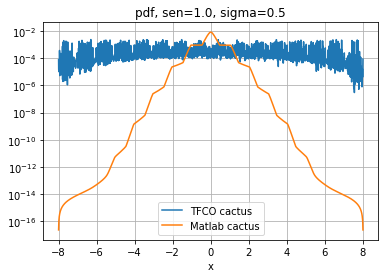

In [4]:
import matplotlib.pyplot as plt

variance = C

filename = ('/home/fwei16/privacy_data/cactus_x_d%.1f_v%.2f.csv' %(sen,variance))
cactus_x = np.genfromtxt(filename, dtype=np.float32)
cactus_x = cactus_x.reshape([len(cactus_x),1])

filename = ('/home/fwei16/privacy_data/cactus_p_d%.1f_v%.2f.csv' %(sen,variance))
cactus_pdf = np.genfromtxt(filename, dtype=np.float32)
cactus_pdf = cactus_pdf.reshape([len(cactus_pdf),1])

plt.figure()
trained_p = p.numpy()
plt.semilogy(cactus_x,trained_p, label=('TFCO cactus'))
plt.semilogy(cactus_x,cactus_pdf, label=('Matlab cactus'))
plt.xlabel('x')
plt.title('pdf, sen=%1.1f, sigma=%.1f' %(sen, np.sqrt(variance)))
plt.legend()
plt.grid(True)